In [16]:
import torch
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from trl import SFTTrainer, SFTConfig
from torch.optim import SGD
import json
import matplotlib.pyplot as plt
from task_vectors import TaskVector

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Model and Tokenizer
pre_model_name = "meta-llama/Llama-3.2-1B"


Using device: cuda


In [3]:
model_paths =[]
model_paths.append(pre_model_name)
for i in range(10):
    model_path_i = f"./output/20241209_162400_epochs5_bs30_lr0.05/models/model_train_{i}"
    model_paths.append(model_path_i)

In [4]:
engrams = []
for i in range(len(model_paths) - 1):
    engram_i = TaskVector(model_paths[i], model_paths[i+1])
    engrams.append(engram_i)

In [5]:
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# File paths
dataset_path = "d2p_each_dataset.json"
with open(dataset_path, 'r') as f:
    dataset = json.load(f)



# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Prepare Train and Test Datasets
train_datasets = []
test_datasets = []

for idx, individual_data in enumerate(dataset):    
    # Prepare Train and Test Data
    train_data = individual_data['train']
    test_data = individual_data['test']

    # Convert to Hugging Face Dataset
    train_dataset = Dataset.from_dict({
        'text': [item['prompt'] + item['completion'] for item in train_data]
    }).map(tokenize_function, batched=True)
    
    test_dataset = Dataset.from_dict({
        'text': [item['prompt'] + item['completion'] for item in test_data]
    }).map(tokenize_function, batched=True)

    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)


Map: 100%|██████████| 10/10 [00:00<00:00, 1812.03 examples/s]


In [6]:
# load model then retrun eval loss


model = AutoModelForCausalLM.from_pretrained(model_paths[0]).to(device)
test_datasets = test_datasets[:10]

In [20]:
def get_eval_loss_on_model(model, test_dataset):
    eval_results = {}
    training_args = TrainingArguments(
        output_dir="./results",
        report_to=["none"],
    )
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        max_seq_length=128,
        args=training_args, 
    )

    results = {}
    for test_idx, test_dataset in enumerate(test_datasets):
        eval_results = trainer.evaluate(eval_dataset=test_dataset)
        eval_loss = eval_results['eval_loss']
        results[test_idx] = eval_loss
    return results

In [21]:
pretrained_model_results = get_eval_loss_on_model(model, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [22]:
pretrained_model_add_0 = engrams[0].apply_to(model_paths[0]).to(device)
pretrained_model_add_0_results = get_eval_loss_on_model(pretrained_model_add_0, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [23]:
pretrained_model_add_0_results

{0: 0.9289805293083191,
 1: 3.537461042404175,
 2: 3.93428373336792,
 3: 3.3638534545898438,
 4: 3.4919991493225098,
 5: 3.8509128093719482,
 6: 3.5373313426971436,
 7: 3.626887559890747,
 8: 3.901533603668213,
 9: 3.292078733444214}

In [24]:
model_0 = AutoModelForCausalLM.from_pretrained(model_paths[1]).to(device)

In [33]:
model_0_results = get_eval_loss_on_model(model_0, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [26]:
pretrained_model_add_1 = engrams[1].apply_to(model_paths[0]).to(device)
pretrained_model_add_1_results = get_eval_loss_on_model(pretrained_model_add_1, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [27]:
pretrained_model_add_1_results

{0: 4.614639759063721,
 1: 2.2897868156433105,
 2: 4.312632083892822,
 3: 4.488891124725342,
 4: 3.4810070991516113,
 5: 4.408097267150879,
 6: 3.911869525909424,
 7: 4.630328178405762,
 8: 4.062893867492676,
 9: 3.624128818511963}

In [34]:
model_0_results 

{0: 0.9289804697036743,
 1: 3.5374608039855957,
 2: 3.934284210205078,
 3: 3.3638534545898438,
 4: 3.4920005798339844,
 5: 3.8509140014648438,
 6: 3.5373318195343018,
 7: 3.626887083053589,
 8: 3.90153431892395,
 9: 3.2920784950256348}

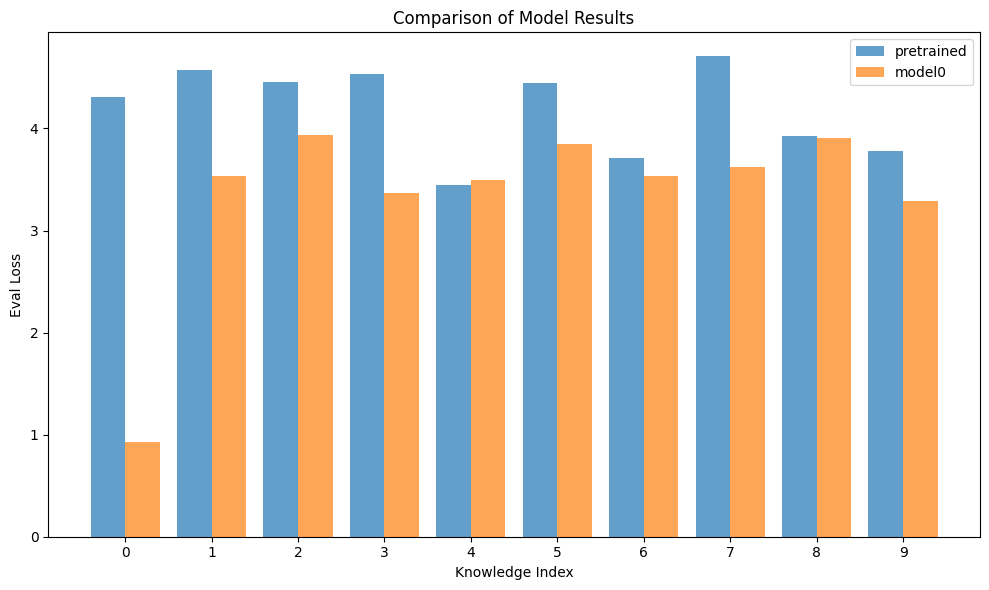

In [38]:
import matplotlib.pyplot as plt

def plot_comparison_bar_graph(data1, data2, labels1="label1", labels2="label2", title="Comparison of Model Results"):
    # Extract keys and values
    keys1, values1 = list(data1.keys()), list(data1.values())
    keys2, values2 = list(data2.keys()), list(data2.values())

    # Ensure keys are the same for both data
    assert keys1 == keys2, "Both datasets must have the same keys."
    
    # Set bar width and positions
    bar_width = 0.4
    bar_positions1 = range(len(keys1))
    bar_positions2 = [pos + bar_width for pos in bar_positions1]

    # Plot bars
    plt.figure(figsize=(10, 6))
    plt.bar(bar_positions1, values1, width=bar_width, label=labels1, alpha=0.7)
    plt.bar(bar_positions2, values2, width=bar_width, label=labels2, alpha=0.7)

    # Add labels and title
    plt.xlabel("Knowledge Index")
    plt.ylabel("Eval Loss")
    plt.title(title)
    plt.xticks([pos + bar_width / 2 for pos in bar_positions1], keys1)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_comparison_bar_graph(pretrained_model_results, model_0_results, "pretrained", "model0")


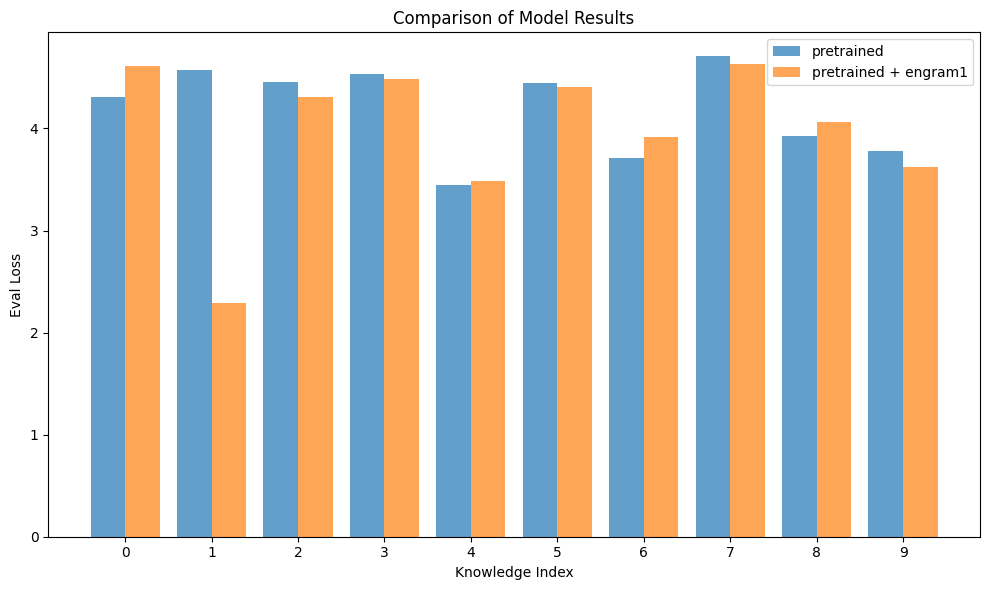

In [39]:



plot_comparison_bar_graph(pretrained_model_results, pretrained_model_add_1_results, "pretrained", "pretrained + engram1")


In [44]:
def make_model_with_add_engram(model_path, engram):
    #engram : TaskVector
    new_model = engram.apply_to(model_path)
    return new_model

def make_model_with_subtract_engram(model_path, engram):
    #engram : TaskVector
    neg_engram = -engram
    new_model = neg_engram.apply_to(model_path)
    return new_model  

In [48]:
model9 = AutoModelForCausalLM.from_pretrained(model_paths[10]).to(device)
model9_results = get_eval_loss_on_model(model_9, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [46]:
model9_minus_engram9 = make_model_with_subtract_engram(model_paths[10], engrams[9]).to(device)
model9_minus_engram9_results = get_eval_loss_on_model(model9_minus_engram9, test_datasets)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


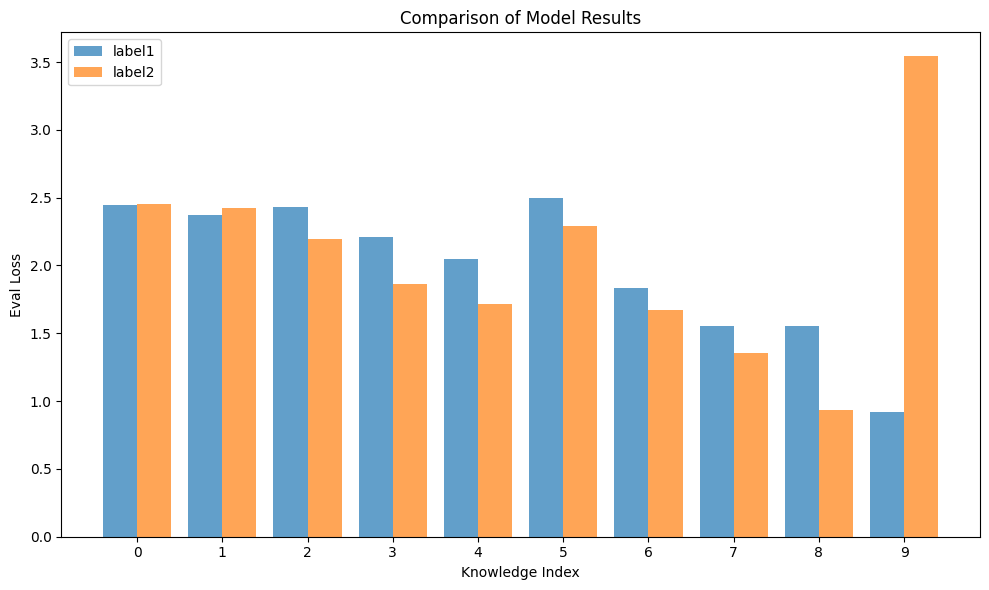

In [49]:
plot_comparison_bar_graph(model9_results, model9_minus_engram9_results)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


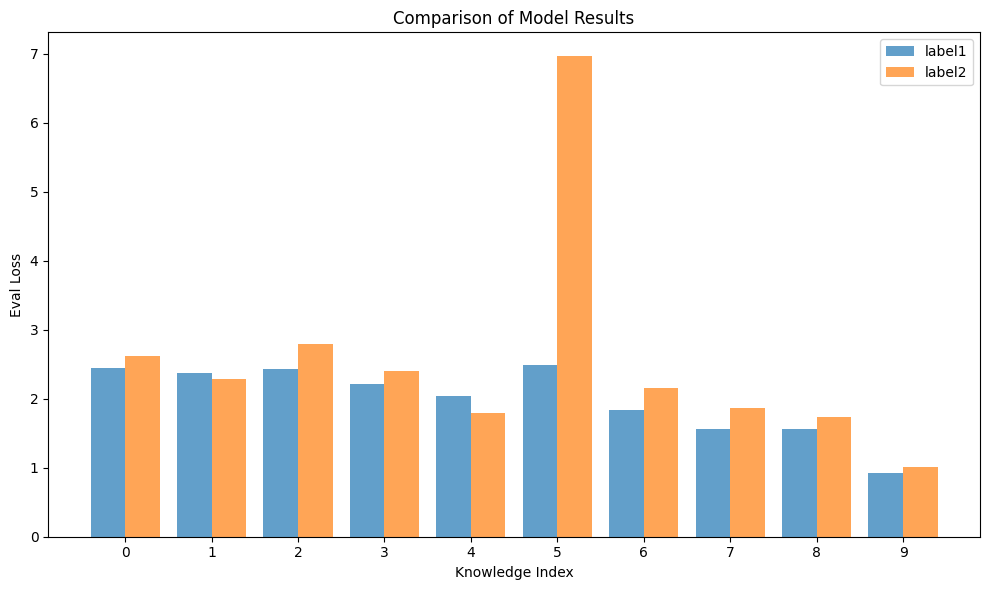

In [50]:


model9_minus_engram5 = make_model_with_subtract_engram(model_paths[10], engrams[5]).to(device)
model9_minus_engram5_results = get_eval_loss_on_model(model9_minus_engram5, test_datasets)
plot_comparison_bar_graph(model9_results, model9_minus_engram5_results)

/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/minsungkim/.conda/envs/fact/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


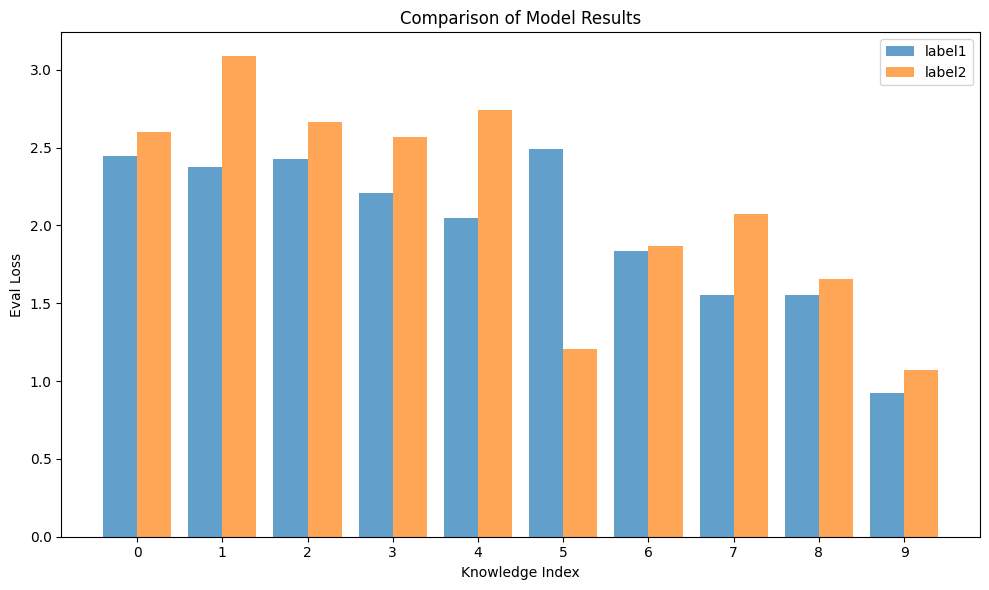

In [51]:
model9_minus_engram5 = make_model_with_add_engram(model_paths[10], engrams[5]).to(device)
model9_minus_engram5_results = get_eval_loss_on_model(model9_minus_engram5, test_datasets)
plot_comparison_bar_graph(model9_results, model9_minus_engram5_results)